In [13]:
import os
import PIL
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model

In [14]:
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.applications import VGG16
from tensorflow.keras.regularizers import l2
#from keras.preprocessing import image
num_classes = 4

IMAGE_SIZE = [256, 256]  # we will keep the image size as (64,64). You can increase the size for better results. 

# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

model = Model(inputs = vgg.input, outputs = x)

In [15]:
train_dir ='/Users/aayushrangra/Desktop/GrapeVine_Disease_Detection/custom_dataset/train'
valid_dir ='/Users/aayushrangra/Desktop/GrapeVine_Disease_Detection/custom_dataset/valid'
test_dir = '/Users/aayushrangra/Desktop/GrapeVine_Disease_Detection/custom_dataset/test'


In [16]:
IMAGE_SIZE = [256, 256]

train_gen = ImageDataGenerator(
    rescale=1./255
    )
val_gen = ImageDataGenerator(
    rescale=1./255
    )  
test_gen = ImageDataGenerator(
    rescale=1./255
    )


train_set = train_gen.flow_from_directory(
    train_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
    )
val_set = val_gen.flow_from_directory(
    valid_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
    )
test_set = test_gen.flow_from_directory(
    test_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
)

Found 25170 images belonging to 4 classes.
Found 5395 images belonging to 4 classes.
Found 5396 images belonging to 4 classes.


In [24]:
from tensorflow.keras.metrics import Precision, Recall, AUC

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
    metrics=['accuracy', Precision(), Recall(), AUC()]
    )

In [25]:
VGG_model = model.fit(
     train_set,
     validation_data=val_set, 
     epochs=10,
     steps_per_epoch = len(train_set),
     validation_steps = len(val_set),)

Epoch 1/10
1574/1574 [==============================] - 661s 420ms/step - loss: 0.2215 - accuracy: 0.9168 - precision: 0.9274 - recall: 0.9061 - auc: 0.9907 - val_loss: 0.0766 - val_accuracy: 0.9728 - val_precision: 0.9733 - val_recall: 0.9718 - val_auc: 0.9988
Epoch 2/10
1574/1574 [==============================] - 755s 480ms/step - loss: 0.0833 - accuracy: 0.9696 - precision: 0.9709 - recall: 0.9687 - auc: 0.9986 - val_loss: 0.0461 - val_accuracy: 0.9848 - val_precision: 0.9850 - val_recall: 0.9844 - val_auc: 0.9995
Epoch 3/10
1574/1574 [==============================] - 1024s 651ms/step - loss: 0.0523 - accuracy: 0.9826 - precision: 0.9831 - recall: 0.9821 - auc: 0.9994 - val_loss: 0.0389 - val_accuracy: 0.9867 - val_precision: 0.9867 - val_recall: 0.9867 - val_auc: 0.9995
Epoch 4/10
1574/1574 [==============================] - 1170s 743ms/step - loss: 0.0402 - accuracy: 0.9867 - precision: 0.9869 - recall: 0.9863 - auc: 0.9997 - val_loss: 0.0295 - val_accuracy: 0.9911 - val_precisi

In [26]:
VGG_model.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])

In [27]:
acc = VGG_model.history['accuracy']
val_acc = VGG_model.history['val_accuracy']

loss = VGG_model.history['loss']
val_loss = VGG_model.history['val_loss']

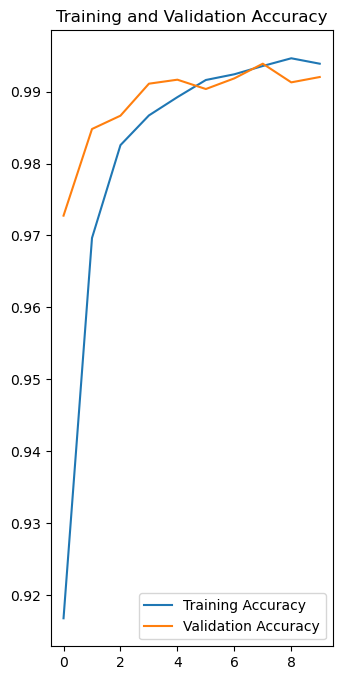

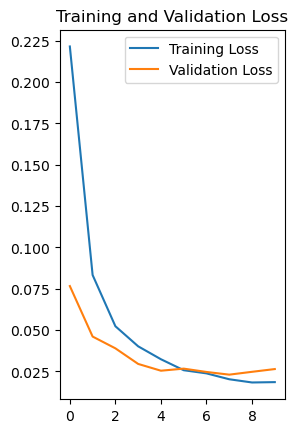

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
predictions = model.predict(test_set)

338/338 [==============================] - 175s 520ms/step


In [30]:
y_pred = np.argmax(predictions, axis=-1)

In [31]:
test_set.class_indices

{'Grape Black rot': 0,
 'Grape Esca Black Measles': 1,
 'Grape Leaf blight Isariopsis Leaf Spot': 2,
 'Grape healthy': 3}

In [32]:
scores = model.evaluate(test_set, batch_size=16, verbose=2)

338/338 - 179s - loss: 0.0214 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9930 - auc: 0.9999 - 179s/epoch - 529ms/step
